In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import fenics
import dolfin
from fenics import *
from hmm.stokes import StokesData, StokesHMMWrapper, HyperParams
from util.basis_scaled import *
from dolfin import *
import matplotlib.pyplot as plt
from util.plot_tools import remove_axes, remove_top_right_axes, plot_periodic
from mshr import *
import boundary_solvers.geometry as geom
import boundary_solvers.gauss_grid_2d as grd
from util.interp import PiecewiseInterp2D
import time

from mshr.cpp import CSGScaling, CSGTranslation

First, we set up the FeniCS solvers.

In [2]:
# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):
    def __init__(self, dom, y0):
        SubDomain.__init__(self)
        self.L = dom[0][1] - dom[0][0]
        self.dom = dom
        self.y0 = y0

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        #return bool(near(x[0], self.dom[0][0]) and not (near(x[1], self.dom[1][1]) or near(x[1], self.y0)) and on_boundary)
        return bool(near(x[0], self.dom[0][0]) and on_boundary)
        #return bool(x[0]-data.dom[0][0] < DOLFIN_EPS and x[0]-data.dom[0][0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - self.L
        y[1] = x[1]

def fenicsSolve(data, info, roof_Nx=50, floor_Nx=50, resolution=10):      
    L = data.dom[0][1]-data.dom[0][0]
    W = data.dom[1][1]-data.dom[1][0]
    freq_g = info['freq_g']
    amp = info['amp']
    eval_pos = info['eval_pos']

    wall_Nx = int(roof_Nx * W/L)

    outlet_x = np.ones(wall_Nx-2) * data.dom[0][1]
    outlet_y = np.linspace(data.f(0), data.dom[1][1], wall_Nx)[1:-1]
    pts = [Point(x, y) for x, y in zip(outlet_x, outlet_y)]

    roof_x = np.linspace(data.dom[0][0], data.dom[0][1], roof_Nx)
    roof_y = data.dom[1][1] * np.ones(roof_Nx)
    pts = pts + [Point(x, y) for x, y in zip(roof_x[::-1], roof_y[::-1])]

    inlet_x = np.ones(wall_Nx-2) * data.dom[0][0]
    inlet_y = np.linspace(data.dom[1][1], data.f(0), wall_Nx)[1:-1]
    pts = pts + [Point(x, y) for x, y in zip(inlet_x, inlet_y)]

    floor_x = np.linspace(data.dom[0][0], data.dom[0][1], floor_Nx)
    floor_t = np.linspace(0, np.pi/2, floor_Nx)
    floor_y = data.f(floor_t) + eval_pos
    pts = pts + [Point(x, y) for x, y in zip(floor_x, floor_y)]

    domain = Polygon(pts)
    
    t = time.time()
    dom_mesh = generate_mesh(domain, resolution=resolution)
    print(f'Meshing time: {time.time()-t}')
    
    # Define the four boundaries + circle
    inflow = f'near(x[0], {data.dom[0][0]})'
    outflow = f'near(x[0],{data.dom[0][1]})'
    roof = f'near(x[1],{data.dom[1][1]}, {DOLFIN_EPS})'
    floor = f'on_boundary && !({inflow} || {outflow} || {roof})'

    # Define the function spaces
    pb = PeriodicBoundary(data.dom, data.f(0))
    P2 = VectorElement(family='P', cell=triangle, degree=2)
    P1 = FiniteElement(family='P', cell=triangle, degree=1)
    P2P1 = P2 * P1
    W = FunctionSpace(dom_mesh, P2P1, constrained_domain=pb)
    U = W.sub(0)#extract_sub_space([0])        
    
    # Forces
    f = Constant((0,0))
    n = FacetNormal(dom_mesh)
    
    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)

    # Boundary Conditions
    #bcu_roof = DirichletBC(U, Constant((1, 0)), roof)
    bcu_roof = DirichletBC(U, Expression((f'{data.dom[1][1]} * (1 + (sin(2*pi*x[0]/{L})*0.4 + sin({freq_g}*2*pi*x[0]/{L})*0.6) * {amp}) ', '0'), degree=2), roof)
    #dom[1][1]*(1 + (np.sin(2*np.pi * x / Lx)*0.4 + np.sin(freq_g*2*np.pi * x / Lx)*0.6) * amp)
    bcu_floor = DirichletBC(U, Constant((0, 0)), floor)
    bcu = [bcu_roof, bcu_floor]

    t = time.time()
    #F = dot(grad(u)*v, n)*ds - p*dot(v,n)*ds - inner(grad(u),grad(v))*dx + p*div(v)*dx+ dot(u,grad(q))*dx - dot(f ,v)*dx - dot(u, n)*q*ds
    F = - p*dot(v,n)*ds - inner(grad(u),grad(v))*dx + p*div(v)*dx+ dot(u,grad(q))*dx - dot(f ,v)*dx - dot(u, n)*q*ds
    a, L = lhs(F), rhs(F)
    print(f'Assembling time: {time.time()-t}')
    
    t = time.time()
    w = Function(W)
    solve(a == L, w, bcu)
    print(f'Solving time: {time.time()-t}')
    
    return w, W, dom_mesh
            

def extract_components(w, W):
    u=project(w[0], W.sub(0).sub(0).collapse())
    v=project(w[1], W.sub(0).sub(1).collapse())
    p=project(w[2], W.sub(1).collapse())
    return u, v, p

Next, we define hyper parameters for our HMM model.

In [3]:
data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference_3/run_{41}.mat")
eps = info['eps']
hyper = HyperParams(nMic = 5, n_refine=1, xDim=21, yDim=21, width=5.13*eps, height=5.13*eps, tol=1e-5, max_iter=30)
setup = StokesHMMWrapper(data, hyper)

dom = data.dom
eval_pos = info["eval_pos"]
eps = info["eps"]
nper = info["nper"]
Lx = info["Lx"]
bbox = info["bbox"]
Uc = info['Uc']
Vc = info['Vc']
Uyc = info['Uyc']

x = np.linspace(bbox[0][0],bbox[0][1],Uc.shape[0])
y = np.linspace(bbox[1][0],bbox[1][1],Uc.shape[1])
X,Y = np.meshgrid(x,y)

pwlerp = PiecewiseInterp2D(x, y, Uc)
pwlerp_dy = PiecewiseInterp2D(x, y, Uyc)
pwlerp_alpha = lambda x: -pwlerp(x, np.ones_like(x)*eval_pos) / pwlerp_dy(x, np.ones_like(x)*eval_pos)

In [4]:
# u,v,p define and project
w, W, omega = fenicsSolve(data, info, roof_Nx=400, floor_Nx=450, resolution=200) 
w_h, W_h, omega_h = fenicsSolve(data, info, roof_Nx=50, floor_Nx=50, resolution=40)
micro, macro, init = setup.solve()
u_hmm = macro.u.change_dim(101, 101)


Meshing time: 0.956646203994751
Assembling time: 0.019347429275512695
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving time: 14.997193336486816
Meshing time: 0.024893522262573242
Assembling time: 0.008926868438720703
Solving time: 0.4196338653564453Solving linear variational problem.

Convergence (not necessarily to solution) at step 5/30


Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


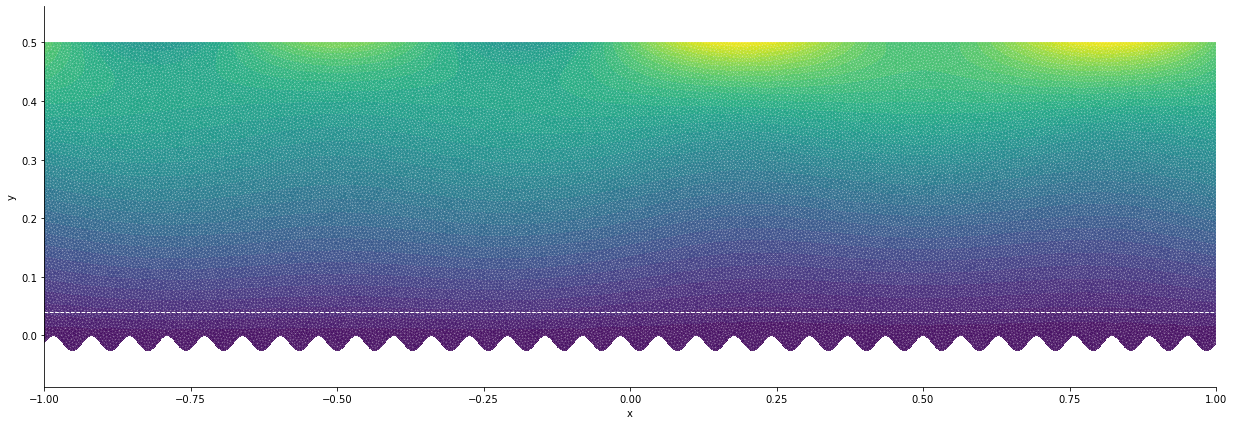

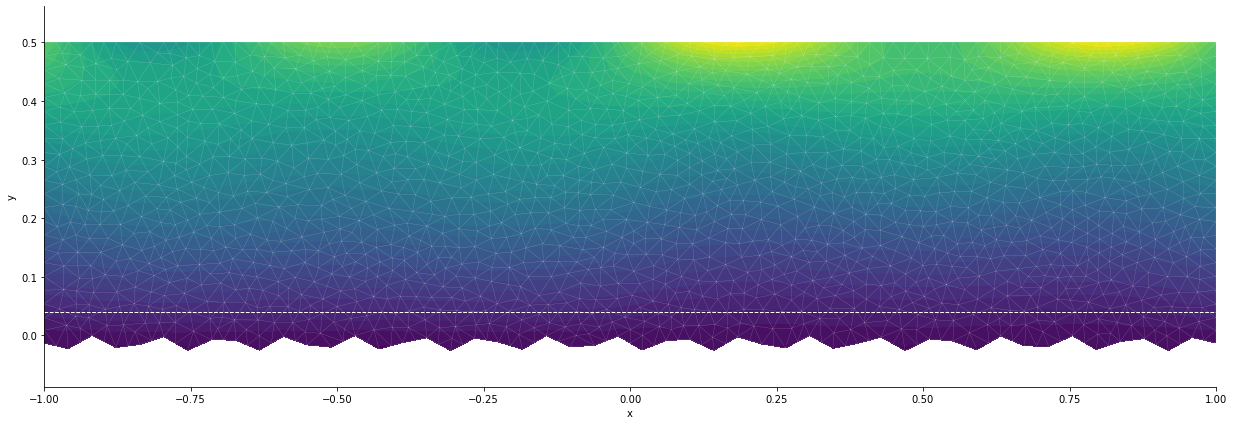

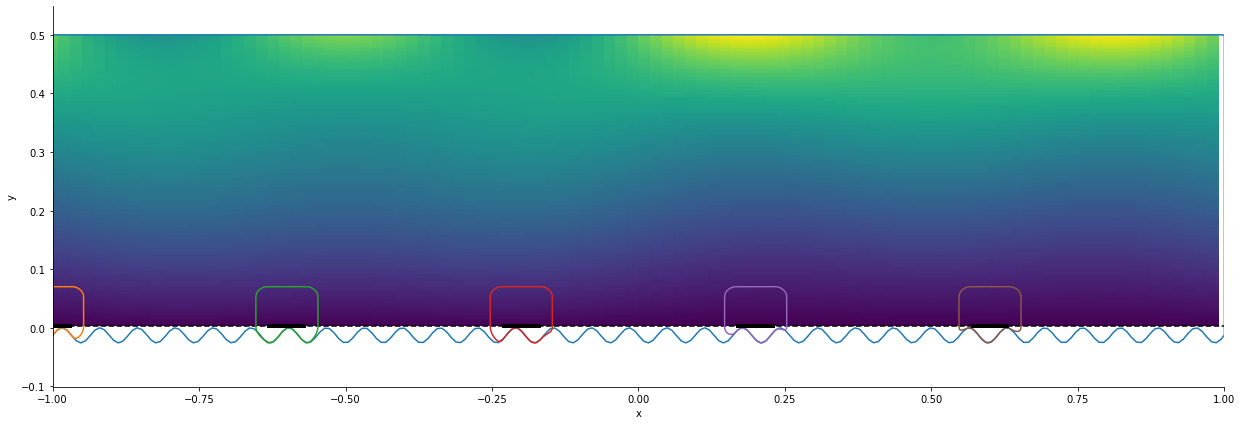

In [5]:
u, v, p = extract_components(w, W)
u_h, v_h, p_h = extract_components(w_h, W_h)

xval = np.linspace(data.dom[0][0], data.dom[0][1], 500)
yval0 = 0.04
yval = yval0 + xval * 0

def adjust_plot(ax):
    remove_top_right_axes(ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.set_xlim(data.dom[0])

plt.figure(figsize=(21,7))
plot((u**2 + v**2)**0.5)
plot(omega, color='white', linewidth=0.1)
plt.plot(xval, yval, 'white', linestyle='--', linewidth=1)
adjust_plot(plt.gca())

plt.figure(figsize=(21, 7))
plot((u_h**2 + v_h**2)**0.5)
plot(omega_h, color='white', linewidth=0.1)
plt.plot(xval, yval, 'white', linestyle='--', linewidth=1)
adjust_plot(plt.gca())

plt.figure(figsize=(21,7))
setup.hmm_problem.plot(plt.gca(), npts=1000)
u_hmm.plot(plt.gca())
adjust_plot(plt.gca())

We also plot the solutions along a line

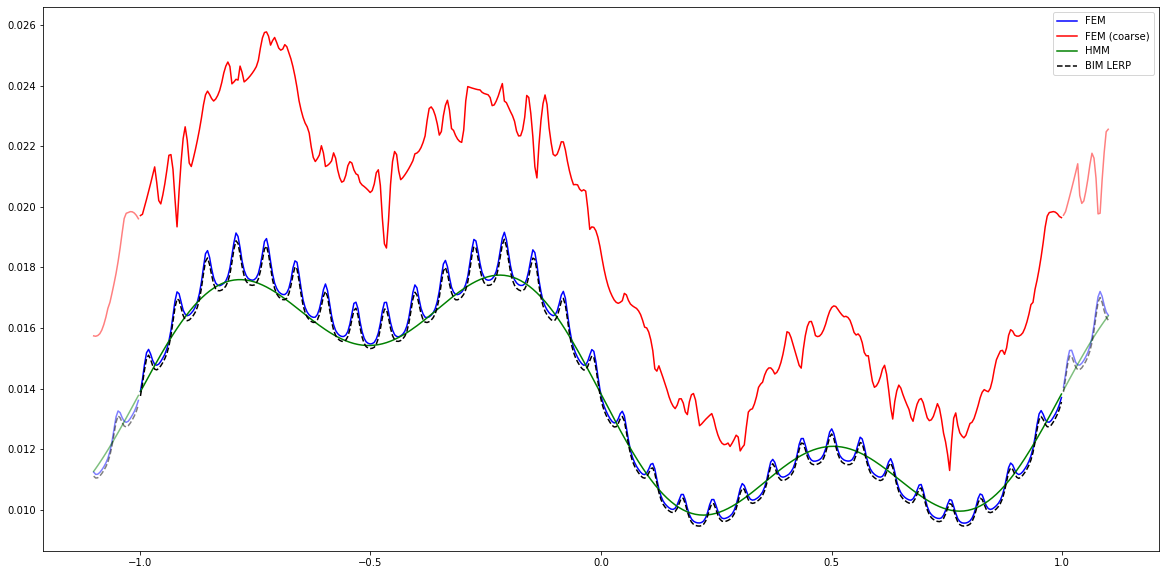

In [6]:
plt.figure(figsize=(20,10))
yval0 = 0.01
line_eval = info['eval_pos'] * 0
ufunc = lambda xs: np.array([u(x, yval0-line_eval) for x in xs])
uhfunc = lambda xs: np.array([u_h(x, yval0-line_eval) for x in xs])
uhmmfunc = lambda xs: u_hmm(xs, np.ones_like(xs)*yval0)
ulerpfunc = lambda xs: pwlerp(xs, np.ones_like(xs)*yval0)

funcs = [ufunc, uhfunc, uhmmfunc, ulerpfunc]
labels = ['FEM', 'FEM (coarse)', 'HMM', 'BIM LERP']
color = ['blue', 'red', 'green', 'black']
linestyle = ['-', '-', '-', '--']

N = 500
for f, l, c, s in zip(funcs, labels, color, linestyle):
    plot_periodic(data.dom[0][0], data.dom[0][1], 0.1, f, N, color=c, label=l, linestyle=s)
plt.legend()